In [1]:
import module_bivar_map as bimap

In [2]:
geo_file = 'GEOJSON/Greenspace_US.geojson'
merge_file = 'merged_greenspace_mh.csv'

In [3]:
## combining geo_df and merge_df to a single dataframe
# laod geo_df and merge_df
geo_df = bimap.load_geo_df_files(geo_file)
merge_df = bimap.load_geo_df_files(merge_file)

# convert UC_Grouping to int
geo_df = bimap.convert_col_type(geo_df, 'UC_Grouping', int)
merge_df = bimap.convert_col_type(merge_df, 'UC_Grouping', int)

# drop columns that are not needed
up_merge_df = bimap.drop_cols(merge_df,['geometry'])

# merge the two dataframes
geo_merge_df = bimap.merge_dfs(geo_df,up_merge_df,'right','UC_Grouping','UC_Grouping')
print(type(geo_merge_df))
geo_merge_df.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,UC_Grouping,geometry,field_1,Population2010,MHLTH_AdjPrev,Latitude,Longitude,E_GR_AV14,E_GR_AT14,SDG_A2G14,...,P15,B15,BUCAP15,GDP15_SM,E_WR_T_14,State,INCM_CMI,DEV_CMI,E_BM_NM_LST,Cities in Urban Center_copy
0,485,"MULTIPOLYGON (((-86.77423 33.59792, -86.76305 ...",0,212237,15.6,33.50902518,-86.82365065,0.494568432,219.99623,0.773811615,...,196387.767,152.8946075,778.5342735,6184143360.0,17.49764442,AL,HIC,MDR,Temperate Broadleaf and Mixed Forests,Birmingham;
1,501,"MULTIPOLYGON (((-86.64499 34.78006, -86.63372 ...",1,180105,13.4,34.72606498,-86.60999497,0.521521752,88.70099915,0.802598906,...,86467.06209,59.6740036,690.1356674,2498489088.0,16.32188892,AL,HIC,MDR,Temperate Broadleaf and Mixed Forests,Huntsville


In [4]:
# keep geometry, state, city, and mental health, one greenspace feature
important_col_list = ['geometry','State','E_WR_T_14','MHLTH_AdjPrev']

df_bimap_raw = bimap.extarct_imp_cols(geo_merge_df,important_col_list)
df_bimap_raw.head(2)

,geometry,State,E_WR_T_14,MHLTH_AdjPrev
0,"MULTIPOLYGON (((-86.77423 33.59792, -86.76305 ...",AL,17.49764442,15.6
1,"MULTIPOLYGON (((-86.64499 34.78006, -86.63372 ...",AL,16.32188892,13.4


In [5]:
# normalize df
fea_col = ['MHLTH_AdjPrev','E_WR_T_14']
df_bimap_nor = bimap.normalize_features(df_bimap_raw, fea_col)
df_bimap_nor.head(2)

,geometry,State,E_WR_T_14,MHLTH_AdjPrev
0,"MULTIPOLYGON (((-86.77423 33.59792, -86.76305 ...",AL,0.655885,0.745283
1,"MULTIPOLYGON (((-86.64499 34.78006, -86.63372 ...",AL,0.602726,0.537736


In [6]:
colorlist = bimap.mikhailsirenko_colorscale()
colorlist[0]

array([[0.39289216, 0.43848039, 0.65686275],
       [0.52401961, 0.46617647, 0.68235294],
       [0.65514706, 0.49387255, 0.70784314],
       [0.78627451, 0.52156863, 0.73333333]])

In [7]:
bimap_df = bimap.assign_color_cells(df_bimap_nor, 'E_WR_T_14', 'c1_env', 'MHLTH_AdjPrev', 'c2_mh')
bimap_df.head(2)

,geometry,State,E_WR_T_14,MHLTH_AdjPrev,c1_env,c2_mh
0,"MULTIPOLYGON (((-86.77423 33.59792, -86.76305 ...",AL,0.655885,0.745283,1,1
1,"MULTIPOLYGON (((-86.64499 34.78006, -86.63372 ...",AL,0.602726,0.537736,1,1


In [8]:
# create city-level bi-variate map
ax = bimap.matplotlib_map(bimap_df, 'c1_env', 'c2_mh', colorlist, xlim= [-125,-70], ylim = [25,50], figsize = (20,20))
bimap.set_off_axis(ax)
bimap.bicolor_legend(ax, colorlist, legend_position = [0,0.1,0.1,0.1], tick_fontsize = 6, label_fontsize = 6, x_label = 'Mental Health', y_label = 'Annual Average Temperature')

TypeError: matplotlib_map() missing 1 required positional argument: 'color_list'

In [ ]:
state_geo_file = 'cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
state_gdf_raw = bimap.load_geo_df_files(state_geo_file)

state_gdf = state_gdf_raw[['STUSPS','geometry']].copy()
state_gdf.head(2)

,STUSPS,geometry
0,MS,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,NC,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


In [ ]:
state_merge_df = merge_df.copy()
 
state_keep_cols =['MHLTH_AdjPrev', 'E_WR_T_14', 'State']
state_drop_cols = [col for col in state_merge_df.columns if col not in state_keep_cols]
state_merge_df = bimap.drop_cols(state_merge_df, state_drop_cols)
state_geo_merge = bimap.merge_dfs(state_gdf, state_merge_df, 'right', 'STUSPS', 'State')
state_geo_merge_norm = bimap.normalize_features(state_geo_merge, ['MHLTH_AdjPrev', 'E_WR_T_14'])

state_geo_merge_norm.drop(columns = ['State'], inplace = True)

# group by state
state_group = state_geo_merge_norm.groupby(by = ['STUSPS','geometry']).mean().reset_index()

# assign colors to cells
state_bimap = bimap.assign_color_cells(state_group, 'E_WR_T_14', 'c1_env', 'MHLTH_AdjPrev', 'c2_mh')


In [ ]:
geo_state = bimap.df_convert_gdf(state_bimap)
print(type(geo_state))
geo_state.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,STUSPS,geometry,MHLTH_AdjPrev,E_WR_T_14,c1_env,c2_mh
0,AK,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...",0.273585,0.000000,3,2
1,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",0.675472,0.686733,1,1


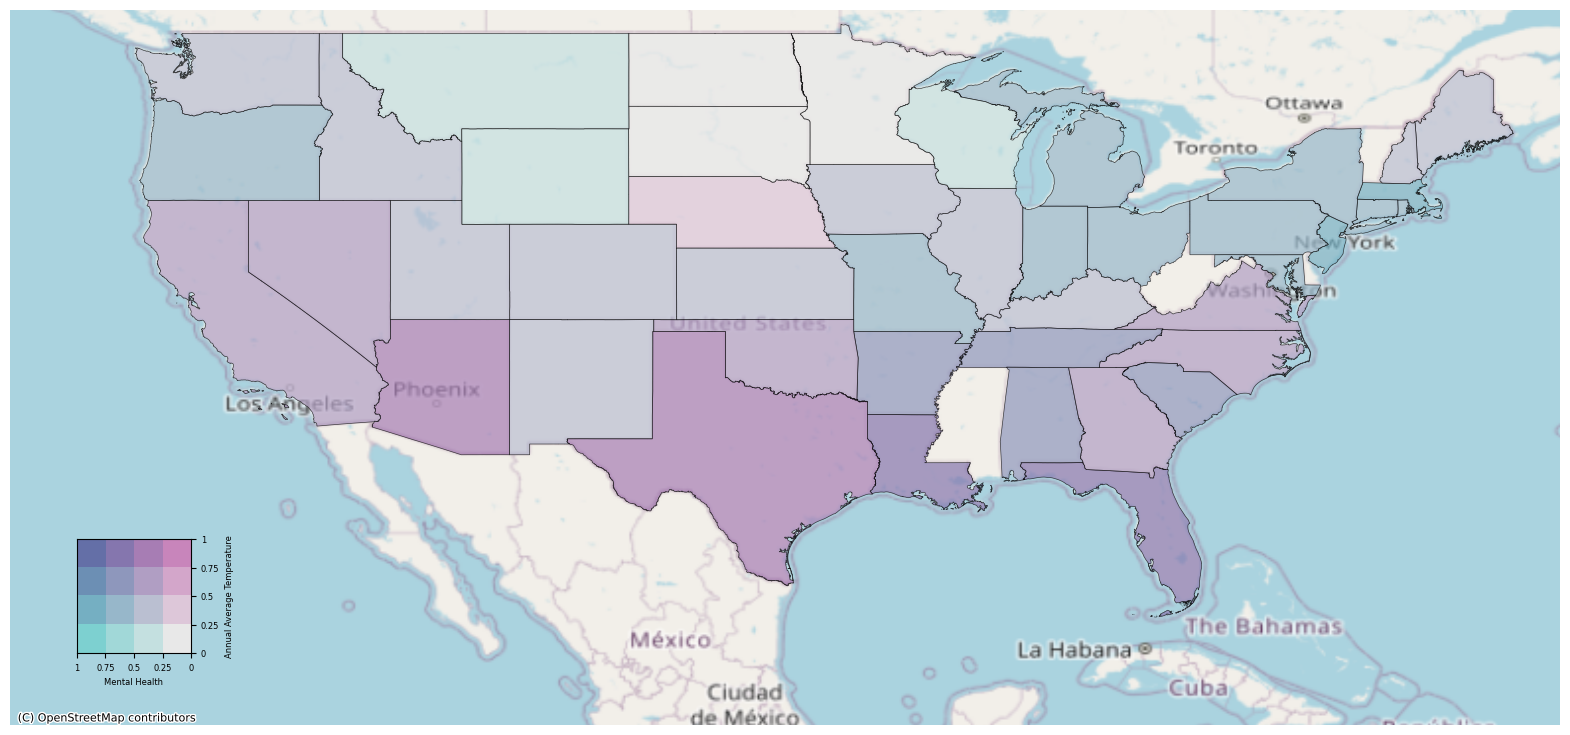

In [ ]:
ax_state = bimap.matplotlib_map(geo_state, 'c1_env', 'c2_mh', colorlist, xlim= [-130,-65], ylim = [20,50], figsize = (20,20),line_width=0.5)
bimap.set_off_axis(ax_state)
bimap.bicolor_legend(ax_state, colorlist, legend_position = [0,0.1,0.16,0.16], tick_fontsize = 6, label_fontsize = 6, x_label = 'Mental Health', y_label = 'Annual Average Temperature')

In [ ]:
bimap_df.head()

,geometry,State,E_WR_T_14,MHLTH_AdjPrev,c1_env,c2_mh
0,"MULTIPOLYGON (((-86.77423 33.59792, -86.76305 ...",AL,0.655885,0.745283,1,1
1,"MULTIPOLYGON (((-86.64499 34.78006, -86.63372 ...",AL,0.602726,0.537736,1,1
2,"MULTIPOLYGON (((-88.09412 30.77126, -88.07220 ...",AL,0.783129,0.688679,0,1
3,"MULTIPOLYGON (((-86.27305 32.41323, -86.22872 ...",AL,0.714978,0.669811,1,1
4,"MULTIPOLYGON (((-87.59002 33.24274, -87.54544 ...",AL,0.676946,0.735849,1,1


# Comparing two states

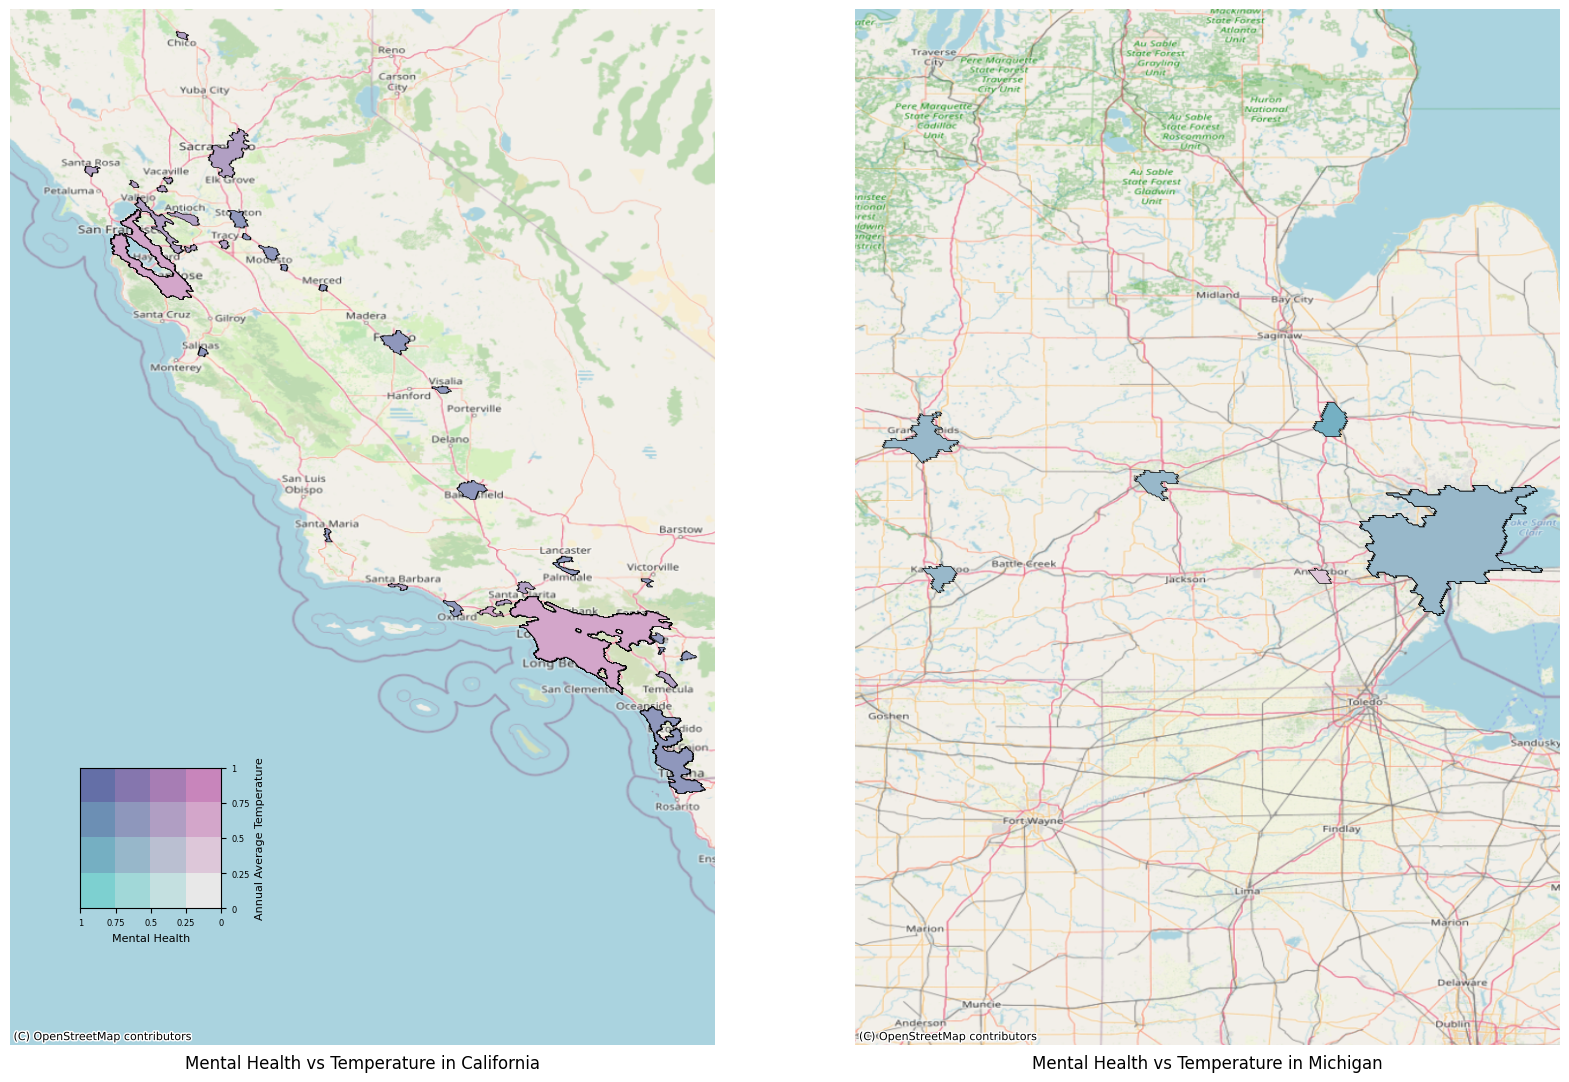

In [41]:
import matplotlib.pyplot as plt

df_ca = bimap_df[bimap_df['State'] == 'CA']
df_mi = bimap_df[bimap_df['State'] == 'MI']

def mat_subplots(n_row, n_col, fig_size = (20,6)):
    fig, axs = plt.subplots(n_row,n_col, figsize = fig_size)
    return fig, axs

fig, axs = bimap.mat_subplots(1,2, (20,20))
ax1,ax2 = axs[0], axs[1]
bimap.matplotlib_map(ax1, df_ca, 'c1_env', 'c2_mh', colorlist, xlim= [-123.5,-116.7], ylim = [30,40])
bimap.matplotlib_map(ax2, df_mi, 'c1_env', 'c2_mh', colorlist, xlim= [-86,-82.6], ylim = [40,45])
bimap.bicolor_legend(ax1, colorlist, legend_position = [0.1,0.1,0.2,0.2], tick_fontsize = 6, label_fontsize = 8, x_label = 'Mental Health', y_label = 'Annual Average Temperature')
bimap.set_off_axis(ax1)
bimap.set_off_axis(ax2)

ax1.set_title('Mental Health vs Temperature in California', fontsize = 12,y=-0.03, loc= 'center')
_ =ax2.set_title('Mental Health vs Temperature in Michigan',fontsize = 12,y=-0.03, loc= 'center')
